# Problem Statement

Aim of this exercise is to get initial insights of the market segment dataset and cluster customers using KMeans/KPrototyes clustering algorithm so that appropriate action can be recommended on each segment and improve the business performance.

KMeans clustering is an unsupervised iterative process where we have to decide number of clusters and their initial cluster center locations. Next, the clusters are assigned to each data entry based on Euclidian distance and then cluster center locations are updated. This process happens iteratively until either we reach fixed number of iterations or there is no more change in cluster center location. KMeans can't handle categorical features. KPrototypes can handle both numeric and categorical features. 

### Methodology
Model development is divided into multiple steps as mentioned below,
- Data exploring and understanding: This step involves preliminary level data understanding and exploring.
- Data Cleaning: This step includes cleaning the existing data. We check the data for any missing values and treat them as per the requirements. We also need to look for constant value colulmns as that is not going to add any additional value to out analysis. Sometimes columns with very high proportion of any particular value also doesn't add any values. Hence, getting rid of them helps with further analysis.
- Data Visualization: This step involves visualizing our dataset and check for relationship amongst independent variables. We can also reduce some feature columns here but it should not be aggressive.
- Data Preparation: This step is mainly usefull for feeding in the data into the model. It involves steps like creating dummy variables, scaling etc. depending upond the data type.
- Model Development-validation and evaluaiton: This steps involves training the model and validate it. It involves evaluating the model using relevant matrics.
- Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

### Dependancies

In [1]:
# Dependancies

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore')

### Reading Dataset

In [2]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Data is having 200 entries and 5 columns. It includes 4 numeric and 1 categorical columns.

- CustomerID: Unique customer ID
- Gender: Customer gender
- Age: Age of the customer
- Annual Income (k$): Customer's annual income
- Spending score (1-100): Score depending upon purchasing behaviour and past data. Range is 1-100.

## 1. Data Exploration and Understanding

In [4]:
# Customer ID

data.CustomerID.nunique()

200

There are 200 unique entries that means each customer is unique in the dataset.

<AxesSubplot:ylabel='Gender'>

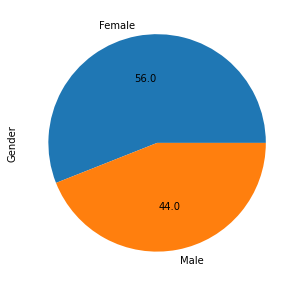

In [5]:
# Gender

data.Gender.value_counts().plot.pie(figsize=(5, 5), autopct="%1.1f")

Customer share for female customers is little higher than male. 

<AxesSubplot:xlabel='Age', ylabel='Density'>

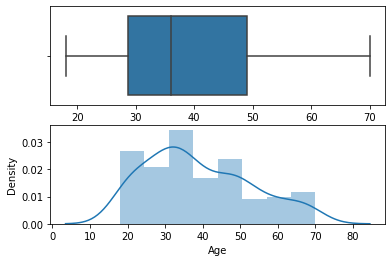

In [6]:
# Age

plt.subplot(2,1,1)
sns.boxplot(data.Age)
plt.subplot(2,1,2)
sns.distplot(data.Age)

Median age of the customers is ~36 yrs. There are no outliers in this column. The distribution looks almost normal.

In [7]:
# rename few columns for convenience of access

data = data.rename(columns={'Annual Income (k$)':'an_inc', 'Spending Score (1-100)': 'spend_score'})
data.head()

,CustomerID,Gender,Age,an_inc,spend_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<AxesSubplot:xlabel='an_inc', ylabel='Density'>

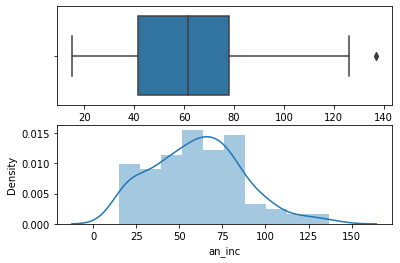

In [8]:
# an_inc

plt.subplot(2,1,1)
sns.boxplot(data.an_inc)
plt.subplot(2,1,2)
sns.distplot(data.an_inc)

Median annual income is around $60k. We observe few outliers in this columns but they aren't large in number. The distribution doesn't look normal.

<AxesSubplot:xlabel='spend_score', ylabel='Density'>

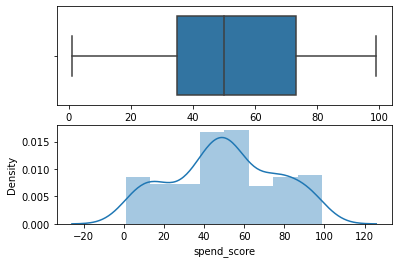

In [9]:
# spend_score

plt.subplot(2,1,1)
sns.boxplot(data.spend_score)
plt.subplot(2,1,2)
sns.distplot(data.spend_score)

Median spend score is around 50. We observe no outliers in this column. The distribution doesn't look normal.

## 2. Data Cleaning

Dataset is having no null entries and also minimal outliers. Hence, we are going to skip this step.

## 3. Data Visualization

<AxesSubplot:>

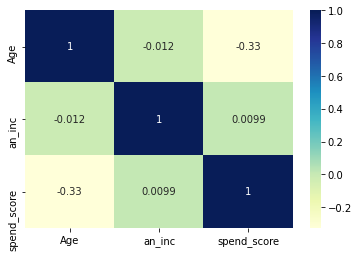

In [10]:
# numeric columns

num_cols = data.select_dtypes(['int64', 'float64']).columns

# removing ID columns 
num_cols = num_cols.drop('CustomerID')

# Heatmapping the correlation

sns.heatmap(data[num_cols].corr(), annot=True, cmap='YlGnBu')

We dont observe any strong relation between numeric data columns here.

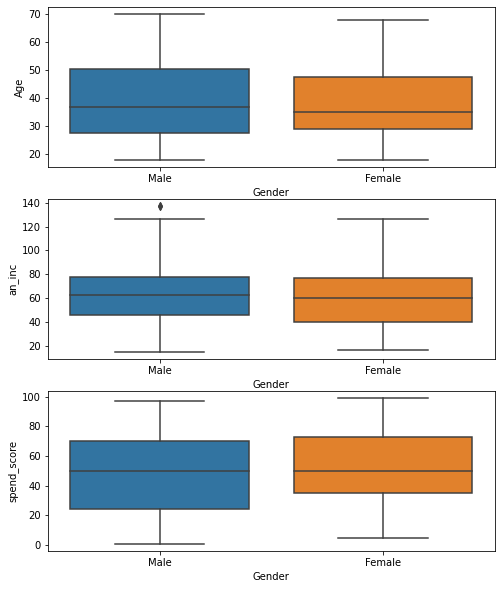

In [11]:
# cat_cols vs num_cols
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x=data['Gender'], y=data[col])
    

Observations,
- Male customers have little higher median age as compared to female with wider spread.
- Male customers have higher median annual income as compared to female.
- Female customers have better median spending score as compared to male.

One point to be noted is that the differences feel very small by looking at the above plots. But still we can exploit them to understand better.

## 4. Data Preparation

KMeans and KModes clustering can deal with only numeric and categorical data columns respectively. If we want to combine both then we need to use KPrototypes clustering.

We we are going to make two models one using KMeans and second using KPrototypes algorithms.
For KMeans we would be using num_cols and for KPrototypes we woud use num_cols and gender column from the dataset.

In [12]:
# encoding 'Gender' column

data.Gender = data.Gender.map({'Male':1, 'Female':0})
data.head()

,CustomerID,Gender,Age,an_inc,spend_score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [13]:
# use StandardScaler for num_cols 

scaler = StandardScaler()

data_s= scaler.fit_transform(data[num_cols])

data_s = pd.DataFrame(data_s, columns=num_cols)
data_s[['CustomerID', 'Gender']] = data[['CustomerID', 'Gender']]
data_s.head()

,Age,an_inc,spend_score,CustomerID,Gender
0,-1.424569,-1.738999,-0.434801,1,1
1,-1.281035,-1.738999,1.195704,2,1
2,-1.352802,-1.700830,-1.715913,3,0
3,-1.137502,-1.700830,1.040418,4,0
4,-0.563369,-1.662660,-0.395980,5,0


In [14]:
# KMeans data

data_km = data_s.drop('Gender', axis=1)

data_km.head()

,Age,an_inc,spend_score,CustomerID
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,2
2,-1.352802,-1.700830,-1.715913,3
3,-1.137502,-1.700830,1.040418,4
4,-0.563369,-1.662660,-0.395980,5


In [15]:
# KPrototypes data

data_kp = data_s
data_kp.head()

,Age,an_inc,spend_score,CustomerID,Gender
0,-1.424569,-1.738999,-0.434801,1,1
1,-1.281035,-1.738999,1.195704,2,1
2,-1.352802,-1.700830,-1.715913,3,0
3,-1.137502,-1.700830,1.040418,4,0
4,-0.563369,-1.662660,-0.395980,5,0


## 5. Model Development-validation and evaluaiton

## KMeans Model

In [16]:
# KMeans k=3 (to divide into 3 segments)

km1 = KMeans(n_clusters=3)
km1.fit(data_km[num_cols])

KMeans(n_clusters=3)

In [17]:
# Checking labels

km1.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       2, 2], dtype=int32)

#### Finding optimum number of clusters using Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

Where,
$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

<AxesSubplot:xlabel='n_clusters', ylabel='sil_score'>

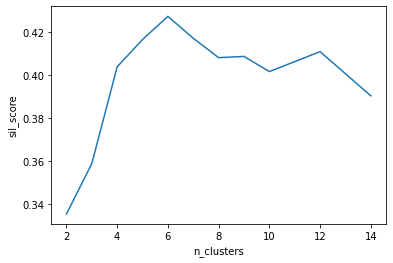

In [18]:
# silhouette analysis
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10, 12, 14]
sil_score = []

for i in n_clusters:
    km = KMeans(n_clusters=i)
    km.fit(data_km[num_cols])
    labels = km.labels_
    # silhouette score
    silhouette_avg = silhouette_score(data_km[num_cols], labels)
    sil_score.append([i, silhouette_avg])
    
sil_score_df = pd.DataFrame(sil_score, columns= ['n_clusters', 'sil_score'])
sns.lineplot(x='n_clusters', y='sil_score', data=sil_score_df)

As per silhoutte score optimum number of clusters is 6, which is little on the higher side. As higher numbers of segments are difficult to explain to the businesss and maintaining each of them is not cost effective. Let's check using inertial based method.

#### Finding optimum number of clusters using  Inertia analysis

It uses sum of squared distance between each point in data to nearest cluster center. Here aim is to minimize the inertia.

<AxesSubplot:xlabel='n_clusters', ylabel='inertia'>

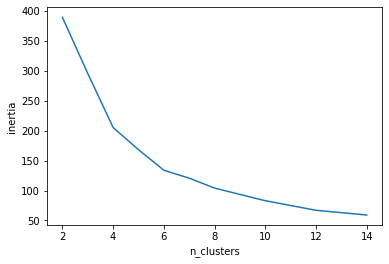

In [19]:
# inertia analysis
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10, 12, 14]
inertia = []

for i in n_clusters:
    km = KMeans(n_clusters=i)
    km.fit(data_km[num_cols])
    # inertia
    inertia.append([i, km.inertia_])
    
inertia_df = pd.DataFrame(inertia, columns= ['n_clusters', 'inertia'])
sns.lineplot(x='n_clusters', y='inertia', data=inertia_df)

Inertia score Vs n_cluster shows the two possible elbows, first at 4 and second at 6. 

We would be considering 4 as optimum number of clusters here.

#### Final model (KMeans)

In [20]:
# final model with k=4

km = KMeans(n_clusters=4)
km.fit(data_km[num_cols])

KMeans(n_clusters=4)

In [21]:
# labelling each entry

data['clus_label_km'] = km.labels_
data.head()

,CustomerID,Gender,Age,an_inc,spend_score,clus_label_km
0,1,1,19,15,39,0
1,2,1,21,15,81,0
2,3,0,20,16,6,0
3,4,0,23,16,77,0
4,5,0,31,17,40,0


#### Understanding the clusters

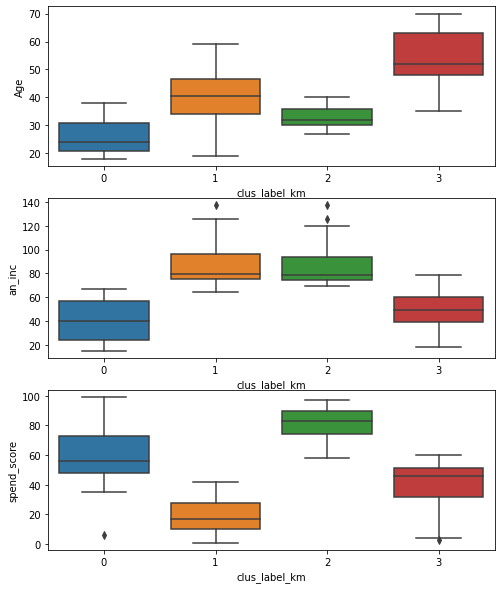

In [22]:
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x='clus_label_km', y=col, data=data)

Observations:

- Cluster 0: It is medium spendimg score cluster with moderate annual income and higher age.
- Cluster 1: It is higher spending score cluster with higher income and relatively young customers.
- Cluster 2: These customers have poor spending score and higher income with relatively older.
- Cluster 3: These are above average spending score customers with lower annual income and young.

This model is clustering the data well but let's check whether we get better clusters using 'Gender' feature column in addition to numeric columns.

## KPrototypes Model

In [23]:
# Instantiating with n_clusters=4
kp1 = KPrototypes(n_clusters=4)
data_kp = data_kp.drop('CustomerID', axis=1)
kp1.fit(data_kp, categorical=[3])

KPrototypes(gamma=0.5, n_clusters=4)

In [24]:
# cost_: Clustering cost, defined as the sum distance of all points to their respective cluster centroids

kp1.cost_

248.45321715208365

#### Finding optimum number of clusters

<AxesSubplot:xlabel='n_clusters', ylabel='cost'>

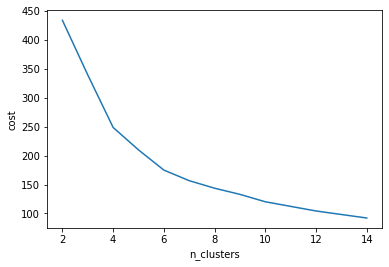

In [25]:
# cost analysis
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10, 12, 14]
cost = []

for i in n_clusters:
    kp = KPrototypes(n_clusters=i)
    kp.fit(data_kp, categorical=[3])
    # cost
    cost.append([i, kp.cost_])
    
cost_df = pd.DataFrame(cost, columns= ['n_clusters', 'cost'])
sns.lineplot(x='n_clusters', y='cost', data=cost_df)

Cost Vs n_cluster shows the two possible elbows, first at 4 and second at 6. 

We would be considering 4 as optimum number of clusters here.

#### Final Model (KPrototypes)

In [26]:
# Instantiating with n_clusters=4

kp = KPrototypes(n_clusters=4)
kp.fit(data_kp, categorical=[3])

KPrototypes(gamma=0.5, n_clusters=4)

In [27]:
# labelling each entry

data['clus_label_kp'] = kp.labels_
data.head()

,CustomerID,Gender,Age,an_inc,spend_score,clus_label_km,clus_label_kp
0,1,1,19,15,39,0,1
1,2,1,21,15,81,0,1
2,3,0,20,16,6,0,1
3,4,0,23,16,77,0,1
4,5,0,31,17,40,0,1


**Important**: Here cluster numbers should not be compared from `clus_label_km` and `clus_label_kp` columns because underlying cluster meaning can be diferent.

#### Understanding clusters

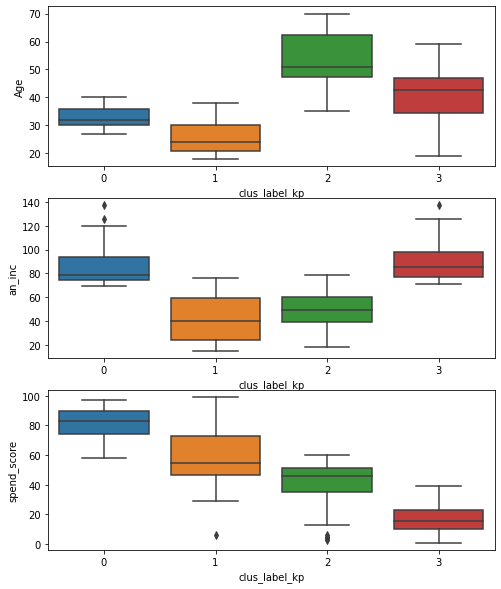

In [28]:
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x='clus_label_kp', y=col, data=data)

Observations:

- Cluster 0: It is medium spendimg score cluster with moderate annual income and higher age.
- Cluster 1: It is higher spending score cluster with higher income and relatively young customers.
- Cluster 2: These customers have moderate spending score and lower income with relatively younger.
- Cluster 3: These are lower spending score customers with higher annual income and moderate age.

Both the models (KMeans and KPrototypes) have created the similar clusters with clusters 2 and 3 swiping.

<AxesSubplot:xlabel='clus_label_kp'>

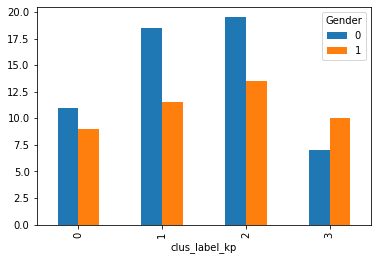

In [29]:
# Categorical column

(pd.crosstab(data['clus_label_kp'], data['Gender'], normalize='all')*100).plot.bar()

Clusters 0, 1, and 2 includes more female whereas it is opposite in cluster 3. Cluster 3 with lower spending score is more represented by male.

## 6. Conclusion/Recommendation

**Conclusion**: KMeans and KPrototypes are suggestng 4 clusters in the dataset. These clusters are showing variation in annual income, age and gender.

**Recommendation** : 
- Lower spending score customers with higher annual income belongs to moderate age. This cluster(kmeans=cluster3 or kprototypes=cluster4) can be targeted with attractive offers suitable to their needs.
- Lower spending customers with moderate income and highers age should be provided with discout offers and credit services so that they can offord more.

-----------